In [37]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [8]:
url = 'http://cnn.com'
body = requests.get(url).text
soup = BeautifulSoup(body, parser='html.parser')

In [9]:
df = pd.read_csv('/dlabdata1/lugeon/websites_alexa_mostpop2.gz', index_col=0)

In [10]:
df

,url,cat0,subcat0
0,http://www.nhentai.net,Adult,Arts
1,http://www.furaffinity.net,Adult,Arts
2,http://www.literotica.com,Adult,Arts
3,http://www.iafd.com,Adult,Arts
4,http://www.sofurry.com,Adult,Arts
...,...,...,...
20056,http://www.nays.org,Sports,Youth_and_High_School
20057,http://www.nhsca.com,Sports,Youth_and_High_School
20058,http://www.naysi.com,Sports,Youth_and_High_School
20059,http://www.chap.com,Sports,Youth_and_High_School


## Using XLM

In [14]:
model_st = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
tokenizer_st = model_st.tokenizer

In [11]:
df['clean_url'] = df.apply(lambda row: row.url[11:].split('.')[0], axis=1)

In [246]:
df['url_tokenize'] = df.apply(lambda row: tokenizer_st.tokenize(row.clean_url), axis=1)

In [12]:
df

,url,cat0,subcat0,clean_url
0,http://www.nhentai.net,Adult,Arts,nhentai
1,http://www.furaffinity.net,Adult,Arts,furaffinity
2,http://www.literotica.com,Adult,Arts,literotica
3,http://www.iafd.com,Adult,Arts,iafd
4,http://www.sofurry.com,Adult,Arts,sofurry
...,...,...,...,...
20056,http://www.nays.org,Sports,Youth_and_High_School,nays
20057,http://www.nhsca.com,Sports,Youth_and_High_School,nhsca
20058,http://www.naysi.com,Sports,Youth_and_High_School,naysi
20059,http://www.chap.com,Sports,Youth_and_High_School,chap


In [13]:
df.cat0.value_counts()

Sports            2969
Business          2221
Computers         1863
Shopping          1664
Arts              1531
Society           1480
Recreation        1445
Health            1407
Science           1130
Games              805
Reference          712
News               703
Home               596
Kids_and_Teens     567
Regional           500
Adult              468
Name: cat0, dtype: int64

In [14]:
df = df.groupby('cat0').sample(468, random_state=42)
df.shape

(7488, 4)

In [15]:
df.reset_index(inplace=True)

In [238]:
df['url_emb_st'] = df.apply(lambda row: model_st.encode(row.clean_url), axis=1)

KeyboardInterrupt: 

In [239]:
x = np.concatenate(df.url_emb_st.to_numpy()).ravel()
x = x.reshape(-1, 768)
x.shape

AttributeError: 'DataFrame' object has no attribute 'url_emb_st'

In [46]:
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

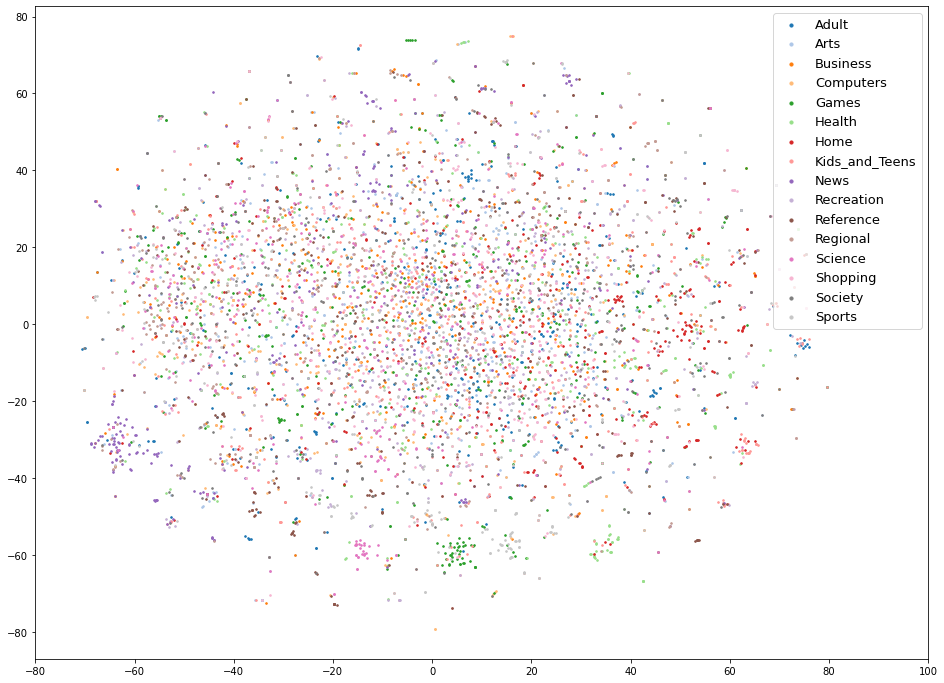

In [49]:
categories = df.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 10
marker = '.'

fig, ax = plt.subplots(figsize=(16, 12))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df[df.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,100])
#ax.set_ylim([0,1])

#ax.set_xticks([], [])
#ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=2, fontsize=13)
plt.plot();

## Using ngrams

In [16]:
def compute_ngram(s, n):
    return [s[i:i+n] for i in range(0, len(s)-n+1)]

def concat_ngrams(s, ns):
    l = []
    for n in ns:
        l += compute_ngram(s, n)
    return list(set(l))

In [17]:
ns = range(3, 7)

df['ngrams'] = df.apply(lambda row: concat_ngrams(row.clean_url, ns), axis=1)

In [22]:
df_ngrams = df[['cat0', 'ngrams']].groupby('cat0').agg(lambda col: [s for l in col for s in l])

In [23]:
def top_ngrams(l):
    return pd.Series(l).value_counts().to_dict()

In [24]:
df_ngrams['top_ngrams_count'] = df_ngrams.apply(lambda row: top_ngrams(row.ngrams), axis=1)

In [25]:
df_ngrams

,ngrams,top_ngrams_count
cat0,,
Adult,"[scl, tusc, usc, tuscl, tus, uscl, there, one,...","{'ult': 22, 'adult': 21, 'dul': 21, 'adu': 21,..."
Arts,"[lass, class, tud, ssr, room, iocla, tudio, as...","{'art': 50, 'ing': 23, 'ine': 21, 'the': 20, '..."
Business,"[vivi, iviu, viviun, viu, iun, viun, viv, vivi...","{'ter': 19, 'ing': 17, 'tra': 17, 'ine': 16, '..."
Computers,"[ina, bina, arie, tbina, altbin, ltbin, naries...","{'ter': 18, 'com': 16, 'ion': 14, 'ech': 13, '..."
Games,"[adak, kkada, adakka, kad, ada, kada, kkad, ad...","{'ame': 69, 'gam': 68, 'game': 64, 'mes': 41, ..."
Health,"[dai, aids, daids, edaids, edaid, pedai, daid,...","{'hea': 30, 'alt': 29, 'eal': 28, 'heal': 27, ..."
Home,"[hicke, kya, back, yardc, chick, ackya, dchic,...","{'ing': 59, 'ome': 29, 'the': 29, 'hom': 25, '..."
Kids_and_Teens,"[iolino, non, lino, inon, nonli, olinon, iol, ...","{'kid': 29, 'kids': 24, 'ids': 24, 'the': 23, ..."
News,"[hea, ve-ho, eav, eave-, heave-, ve-h, ave, e-...","{'new': 87, 'ews': 84, 'news': 84, 'the': 49, ..."


In [277]:
def reduce_ngrams(ngrams_dict, nb_rep_ngrams):
    red = set()
    for s in ngrams_dict.keys(): # candidate
        valid = True
        for t in list(ngrams_dict.keys())[::-1]: # superstring, from longer to shorter
            if s != t:
                if s in t: # if there is a super-string in the ngrams
                    if (ngrams_dict[s] - ngrams_dict[t]) <= 4: # and that there count difference is smaller or equal than 2
                        s = t # discard substring
                        break
        if valid:
            red.add(s)
        if len(red) == nb_rep_ngrams:
            break
                
    return red

In [117]:
a = {'a': 4}
list(a.keys())

['a']

In [153]:
def reduce_ngrams(ngrams_dict, nb_rep_ngrams):
    red = []
    cand_list = list(ngrams_dict.keys())
    for i in range(len(cand_list)):
        cand = cand_list[i]
        valid = True
        better_ngrams = cand_list[:i]
        for better in better_ngrams:
            if better in cand:
                valid = False
                break
        if valid:
            red += [cand]
        if len(red) == nb_rep_ngrams:
            break
    return red

In [306]:
nb_rep_ngrams = 1

df_ngrams['rep_ngrams'] = df_ngrams.apply(lambda row: reduce_ngrams(row.top_ngrams_count, nb_rep_ngrams), axis=1)

In [307]:
all_rep_grams = np.unique([gram for gramlist in df_ngrams.rep_ngrams for gram in gramlist])
all_rep_grams.shape

(12,)

In [308]:
all_rep_grams

array(['all', 'ame', 'art', 'dult', 'healt', 'ica', 'ing', 'ion', 'kid',
       'news', 'sci', 'ter'], dtype='<U5')

In [313]:
def encode_repgrams_onehot(s):
    onehot = np.array([int(gram in s) for gram in all_rep_grams])
    return onehot

In [314]:
df['repgrams_oh'] = df.apply(lambda row: encode_repgrams_onehot(row.clean_url), axis=1)

In [315]:
x = np.concatenate(df.repgrams_oh.to_numpy()).ravel()
x = x.reshape(-1, all_rep_grams.shape[0])
x.shape

(7488, 12)

In [38]:
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

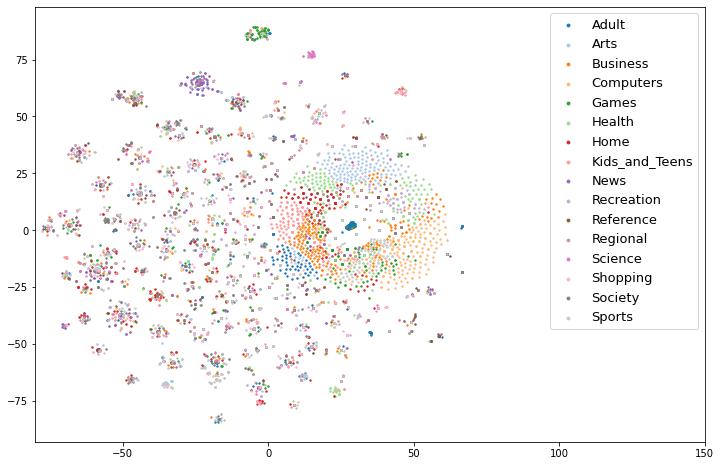

In [39]:
categories = df.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 2
marker = 'o'

fig, ax = plt.subplots(figsize=(12, 8))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df[df.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,150])
#ax.set_ylim([0,1])

#ax.set_xticks([], [])
#ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=2, fontsize=13)
plt.plot();

In [194]:
repgrams_vec = {}
for r in tqdm(all_rep_grams):
    repgrams_vec[r] = model_st.encode(r)

100%|██████████| 145/145 [00:04<00:00, 32.89it/s]


In [223]:
def encode_repgrams_vec(s):
    acc = np.zeros(768)
    i = 0
    for gram in [g for g in all_rep_grams if g in s]:
        acc += repgrams_vec[gram]
        i += 1
    if i == 0:
        return acc
    else:
        return acc / i

In [224]:
df['repgrams_vec'] = df.apply(lambda row: encode_repgrams_vec(row.clean_url), axis=1)

In [227]:
x = np.concatenate(df.repgrams_vec.to_numpy()).ravel()
x = x.reshape(-1, 768)
print(x.shape)
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

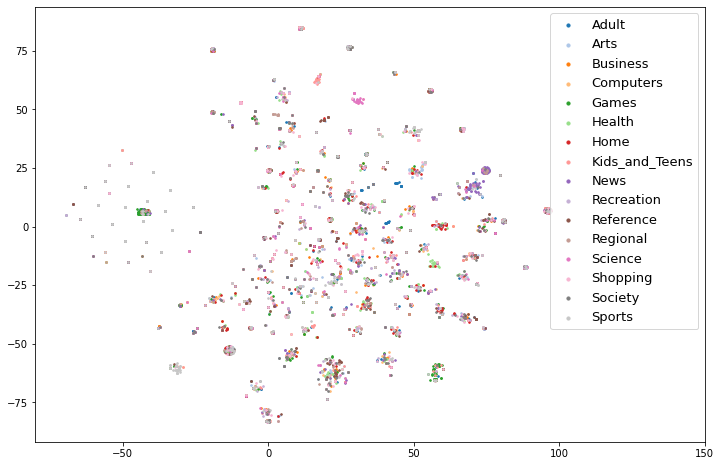

In [228]:
categories = df.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 10
marker = '.'

fig, ax = plt.subplots(figsize=(12, 8))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df[df.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,150])
#ax.set_ylim([0,1])

#ax.set_xticks([], [])
#ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=2, fontsize=13)
plt.plot();

## Classifier on one hot

In [77]:
df.shape

(7488, 8)

In [45]:
from sklearn import svm
from sklearn.model_selection import cross_validate

In [46]:
def categorize(c):
    return categories.tolist().index(c)

In [78]:
df['catno'] = df.apply(lambda row: categorize(row.cat0), axis=1)

In [79]:
y = df.catno.values

### SVM

In [306]:
clf = svm.SVC(kernel='linear', C=1)
scores = cross_validate(clf, x, y, cv=5, scoring='accuracy', return_train_score=True, verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [307]:
scores

{'fit_time': array([11.97078776, 11.94847202, 11.7994349 , 11.64180422, 11.47340369]),
 'score_time': array([1.97466183, 1.90649676, 1.6076889 , 1.54023194, 1.53174305]),
 'test_score': array([0.17823765, 0.20627503, 0.18491322, 0.1750167 , 0.20240481]),
 'train_score': array([0.23522538, 0.22854758, 0.23539232, 0.24119513, 0.23451844])}

In [308]:
scores['test_score'].mean()

0.18936948217752816

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
from tqdm import tqdm

### Random forest with all vectors

In [399]:
maxd = 70

train = []
test = []

for d in tqdm(range(1, maxd+1)):
    forest = RandomForestClassifier(n_estimators=300, max_depth=d, random_state=42)
    forest_scores = cross_validate(forest, x, y, cv=5, scoring='accuracy', return_train_score=True)
    train += [forest_scores['train_score'].mean()]
    test += [forest_scores['test_score'].mean()]

100%|██████████| 70/70 [23:24<00:00, 20.07s/it]


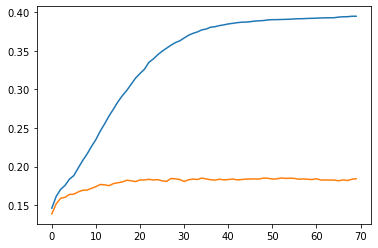

In [401]:
plt.plot(train)
plt.plot(test)
plt.show()

In [54]:
best_d = 35

forest = RandomForestClassifier(n_estimators=300, max_depth=best_d, random_state=42)
forest_scores = cross_validate(forest, x, y, cv=5, scoring=['accuracy', 'precision_macro'], return_train_score=True)

In [55]:
forest_scores

{'fit_time': array([3.94491172, 3.34348178, 3.42921185, 3.32619476, 3.21178007]),
 'score_time': array([0.15565753, 0.13467526, 0.13728166, 0.13107109, 0.13418508]),
 'test_accuracy': array([0.18958611, 0.20093458, 0.17690254, 0.18704075, 0.20641283]),
 'train_accuracy': array([0.40517529, 0.41135225, 0.41252087, 0.41562344, 0.40727758]),
 'test_precision_macro': array([0.28474785, 0.32438013, 0.27887466, 0.28319518, 0.30179173]),
 'train_precision_macro': array([0.67492859, 0.6650341 , 0.66096496, 0.65463835, 0.6398133 ])}

### with only non-null vectors

In [316]:
no_repgram = (df.repgrams_oh.apply(sum) == 0).value_counts()
(no_repgram[True] / (no_repgram[True] + no_repgram[False]))

0.7952724358974359

percentage of url with that does not contain any representative n-grams

In [317]:
x = np.concatenate(df[df.repgrams_oh.apply(sum) != 0].repgrams_oh.to_numpy()).ravel()
x = x.reshape(-1, all_rep_grams.shape[0])
x.shape

(1533, 12)

In [318]:
y = df[df.repgrams_oh.apply(sum) != 0].catno.values

In [319]:
shuffle_ix = np.arange(x.shape[0])
np.random.shuffle(shuffle_ix)
x = x[shuffle_ix]
y = y[shuffle_ix]

In [303]:
maxd = 60

train = []
test = []

for d in tqdm(range(1, maxd+1)):
    forest = RandomForestClassifier(n_estimators=300, max_depth=d, random_state=42)
    forest_scores = cross_validate(forest, x, y, cv=5, scoring='accuracy', return_train_score=True)
    train += [forest_scores['train_score'].mean()]
    test += [forest_scores['test_score'].mean()]

  0%|          | 0/60 [00:02<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-303-2572d3bb9e30>", line 8, in <module>
    forest_scores = cross_validate(forest, x, y, cv=5, scoring='accuracy', return_train_score=True)
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 242, in cross_validate
    scores = parallel(
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/joblib/parallel.py", line 1051, in __call__
    while self.dispatch_one_batch(iterator):
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/dlabdata1/lugeon/lugeon

TypeError: object of type 'NoneType' has no len()

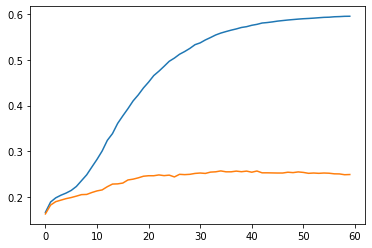

In [394]:
plt.plot(train)
plt.plot(test)
plt.show()

In [320]:
forest = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=42)
forest_scores = cross_validate(forest, x, y, cv=5, scoring=['accuracy', 'precision_weighted'], return_train_score=True, error_score=0)

/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-pack

In [321]:
forest_scores

{'fit_time': array([0.54685163, 0.51178837, 0.5205884 , 0.52628756, 0.45034242]),
 'score_time': array([0.05212665, 0.05246234, 0.05388379, 0.04440188, 0.04397941]),
 'test_accuracy': array([0.30944625, 0.30618893, 0.29315961, 0.29738562, 0.26797386]),
 'train_accuracy': array([0.29200653, 0.29200653, 0.30016313, 0.29502852, 0.30154849]),
 'test_precision_weighted': array([0.32953172, 0.35145601, 0.33231039, 0.31159445, 0.35028257]),
 'train_precision_weighted': array([0.33846671, 0.33391807, 0.33979329, 0.3442125 , 0.33780921])}